Graph Constrained Unmixing w/ Normalized Cuts

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from SuperpixelCutsPy import *
import scipy as sp
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(suppress=True)

In [2]:
dataset_name = 'Salinas A'
hyperspectral_cube = sp.io.loadmat("data/SalinasA_corrected.mat")['salinasA_corrected'] # Load Dataset
ground_truth = sp.io.loadmat("data/SalinasA_gt.mat")['salinasA_gt']
#hyperspectral_cube = hyperspectral_cube[0:55,0:55,:]

#hyperspectral_cube[12,14,:] = hyperspectral_cube[12,10,:]
#ground_truth = ground_truth[0:55,0:55]
# ground_truth = np.vectorize(lambda x: {0: 0, 1:1, 10:2, 11:3, 12:4, 13:5, 14:6}[x])(ground_truth)
nx, ny, nb = hyperspectral_cube.shape
print(hyperspectral_cube.shape)

(83, 86, 204)


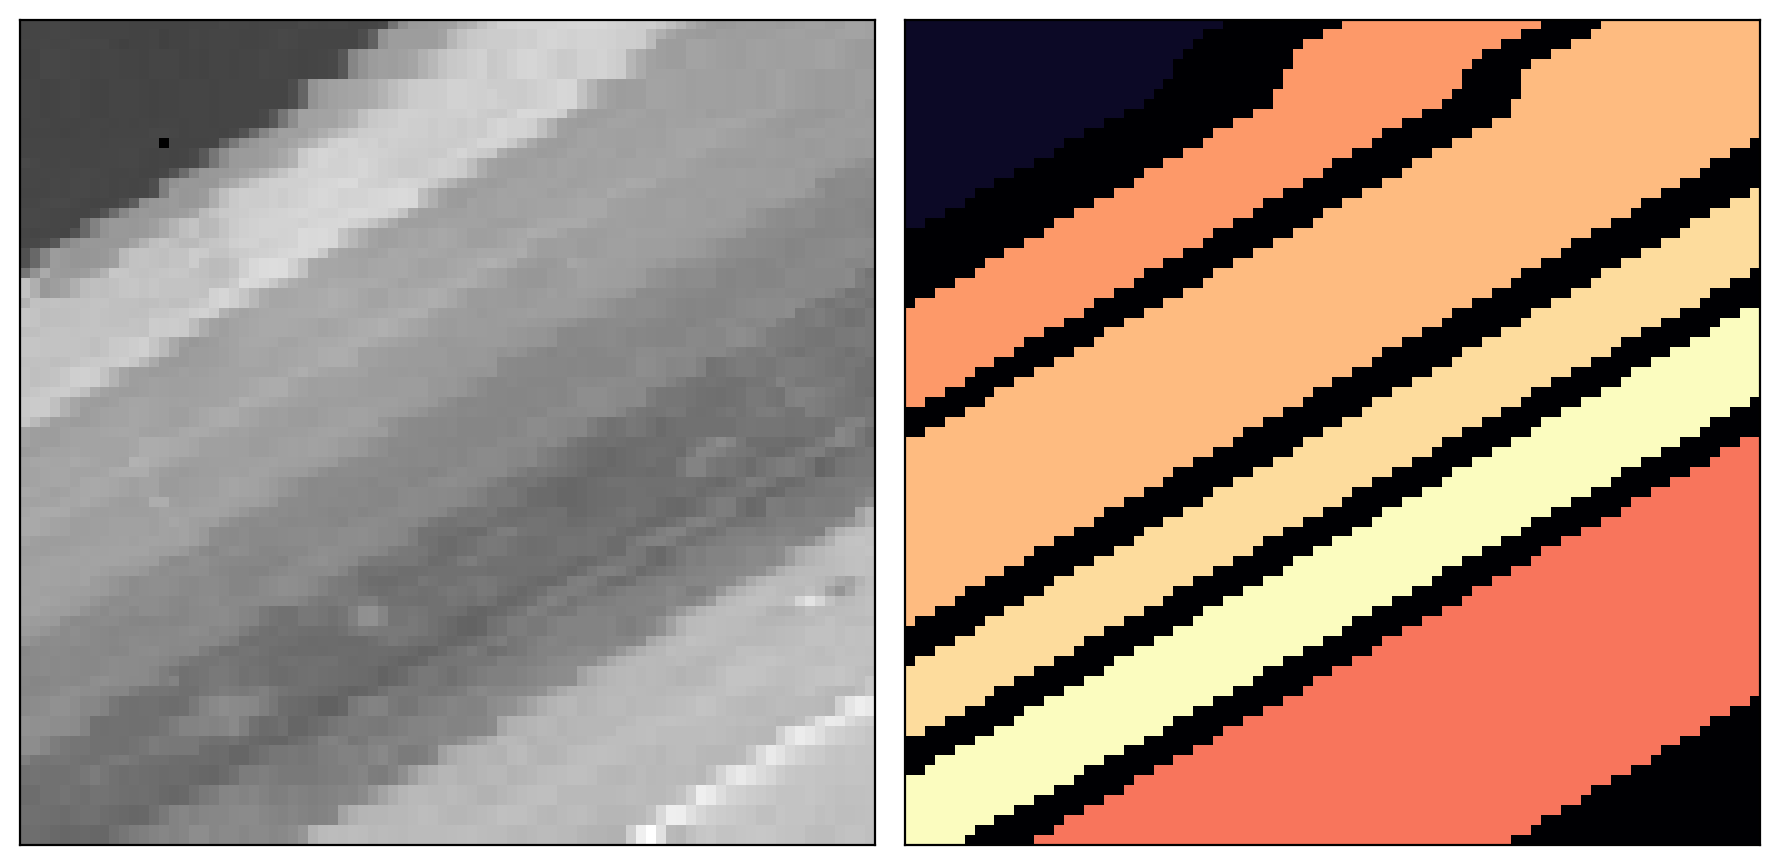

In [3]:

fig, ax = plt.subplots(1,2, dpi=200);
ax[0].imshow(hyperspectral_cube[:,:,25], cmap = 'gray');
# ax.add_patch(rect_c);

ax[1].imshow(ground_truth, cmap = 'magma');
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();


In [4]:
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()

In [5]:
n_superpixels = 250 #2500
slic_m_param = 2  #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))

Adjusting n_superpixels: 272
Created 272 superpixels


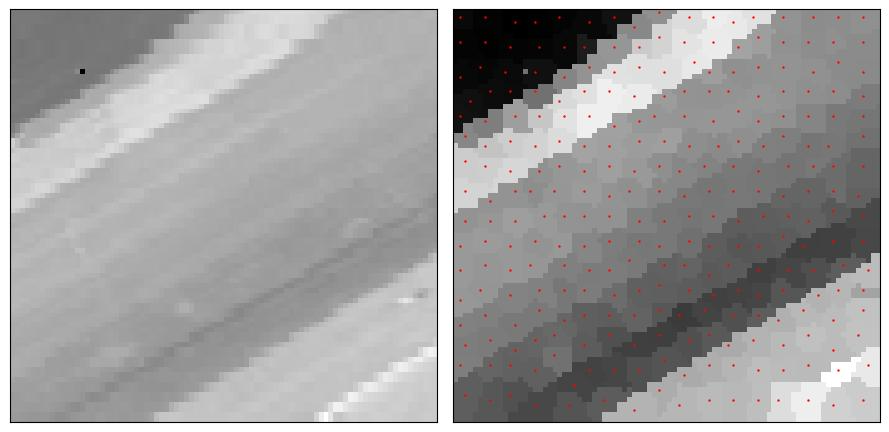

In [6]:
fig, ax = plt.subplots(1,2, dpi=100);
layer_preview = 20
ax[0].imshow(hyperspectral_cube[:,:,layer_preview], cmap = 'gray');
ax[1].imshow(superpixeled_cube[:,:,layer_preview], cmap = 'gray');
ax[1].scatter(centers[:,1], centers[:,0], c='red', s=0.5);
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();
# ax[0].set_title(f'Original Image Layer {layer_preview}', fontsize = 8);
# ax[1].set_title(f'Superpixeled Image n={len(np.unique(assignments))}', fontsize = 8);

In [7]:
sigma_param = 0.005 # 0.1 -> 0.001           #0.01
spatial_limit = 25# 15 -> 25 in steps of 5 #15
spatial_beta_param = 0.005
spatial_dmax_param = 10
ne = 7#number of endmembers

labelled_img, normalized_signatures, int_results = normalized_cuts.graph_regularized_ncuts_admm(data=hyperspectral_cube,
                                                                                                superpixel_library=superpixel_library,
                                                                                                superpixel_centers=centers,
                                                                                                superpixel_assignments=assignments,
                                                                                                n_endmembers = ne,
                                                                                                spectral_sigma2_param= sigma_param,
                                                                                                spatial_kappa_param=spatial_limit,
                                                                                                spatial_beta_param= spatial_beta_param,
                                                                                                spatial_dmax_param = spatial_dmax_param,
                                                                                                n_unmixing_iters = 200,
                                                                                                spectral_metric='SAM')

original_library  = segmentation_evaluation.calc_mean_label_signatures(utility.cube_to_matrix(original_hyperspectral_cube),
                                                                        labelled_img.reshape(-1))

#original_library = segmentation_evaluation.calc_mean_label_signatures(superpixel_original_library, superpixel_cluster_labels)

Initial Clustering
Spectral + Unmixing Clustering


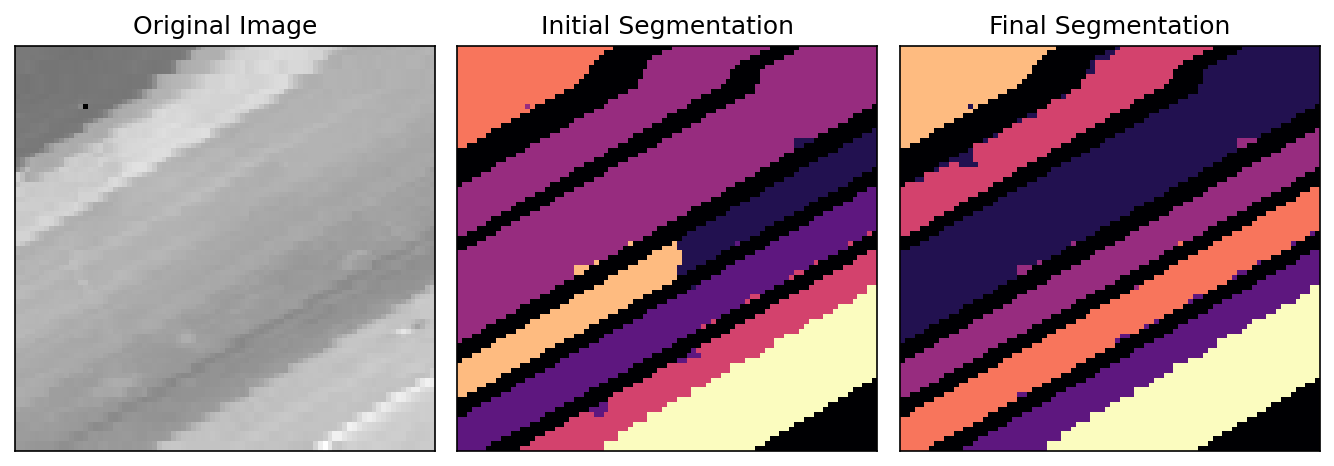

In [8]:
fig, ax = plt.subplots(1,3, dpi=150);
ax[0].imshow(hyperspectral_cube[:,:,layer_preview], cmap = 'gray');
ax[1].imshow((int_results['initial_labels']+1)*(ground_truth != 0), cmap = 'magma');
ax[2].imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');

ax[0].set_title("Original Image");
ax[1].set_title("Initial Segmentation");
ax[2].set_title("Final Segmentation");

ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
ax[2].set_xticks([]);
ax[2].set_yticks([]);
plt.tight_layout();


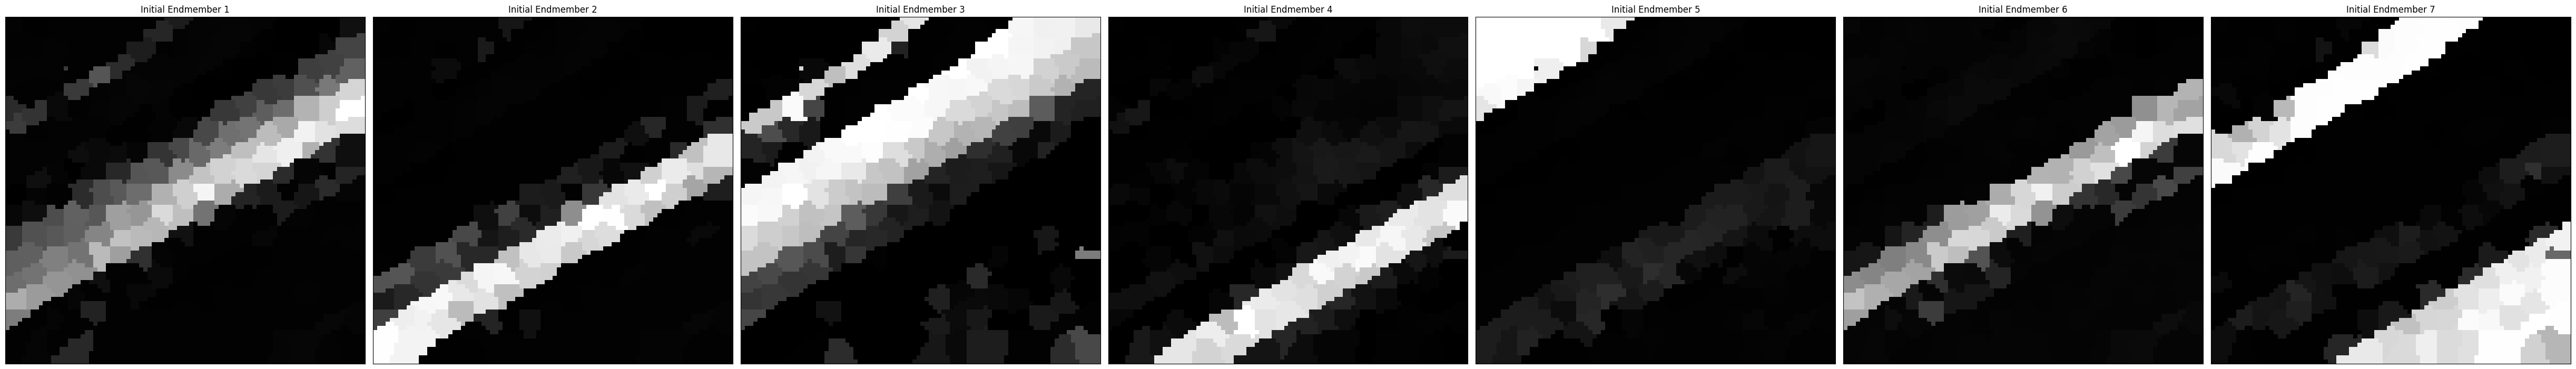

In [9]:
num_layers = min(int_results['abundance_results'].shape[2], ne)

fig, axes = plt.subplots(1, num_layers, figsize=(ne*num_layers, ne))

for i in range(num_layers):
    axes[i].imshow(int_results['abundance_results'][:, :, i], cmap='gray')
    axes[i].set_title(f'Initial Endmember {i+1}')
    axes[i].set_xticks([]);
    axes[i].set_yticks([]);
    
plt.tight_layout();



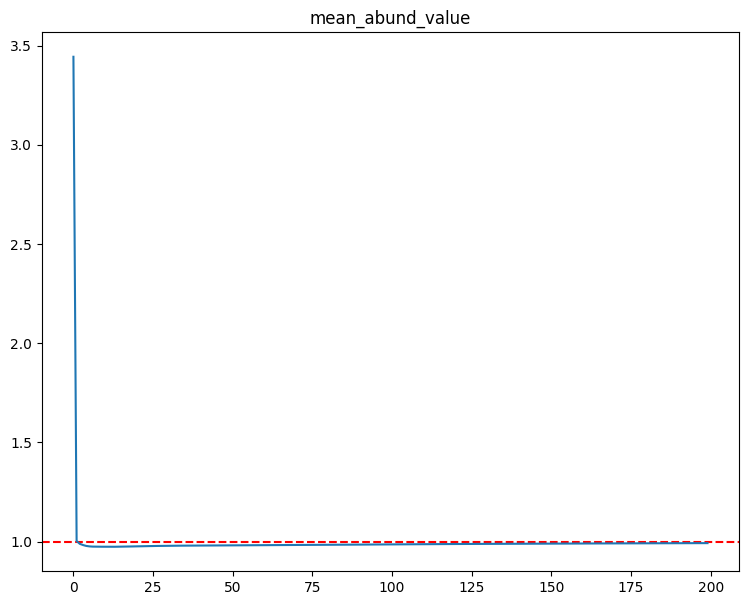

In [10]:
#dict_keys(['loss', 'primal_residual', 'dual_residual', 'mean_abund_value', 'n_iters'])
view = 'mean_abund_value'
plt.axhline(y=1, color='r', linestyle='--');
plt.plot(int_results['unmixing_history'][view]);
plt.title(view);

In [14]:
dataset_name = 'salinas_a_7'
savefigs = True
if savefigs:
    print("Saving Original Image")
    utility.save_hcube(hyperspectral_cube = original_hyperspectral_cube[:,:,25::],
                       n_layers = 50,
                       output_img=f'display_imgs/{dataset_name}_original.png');

    print("Saving Preprocessed Results")
    utility.save_hcube(hyperspectral_cube = hyperspectral_cube[:,:,25::],
                   n_layers = 50,
                   output_img=f'display_imgs/{dataset_name}_preprocessed.png');

    print("Saving Superpixel Results")
    utility.save_hcube(hyperspectral_cube = superpixeled_cube[:,:,25::],
                   n_layers = 40,
                   output_img=f'display_imgs/{dataset_name}_superpixeled.png');

    print("Saving Abundance Results")
    utility.save_hcube(hyperspectral_cube = int_results['abundance_results'],
                   n_layers = ne,
                   output_img=f'display_imgs/{dataset_name}_abundances.png');

    print("Saving Abundance + Superpixel Results")
    step_size = 4
    utility.save_hcube(hyperspectral_cube = np.concatenate([superpixeled_cube[:,:,np.arange(0, nb, step_size)],
                                                            int_results['abundance_results']], axis = 2),
                      n_layers = np.arange(0, nb, step_size).shape[0] + ne,
                      output_img=f'display_imgs/{dataset_name}_superpixel_plus_abudance.png');

    print("Saving Segmentation Results")
    utility.save_img(image = (int_results['initial_labels']+1)*(ground_truth != 0),
                     output_img= f'display_imgs/{dataset_name}_initial_segmentation.png')

    utility.save_img(image = (labelled_img+1)*(ground_truth != 0),
                     output_img= f'display_imgs/{dataset_name}_final_segmentation.png')

Saving Original Image
Saving Preprocessed Results
Saving Superpixel Results
Saving Abundance Results
Saving Abundance + Superpixel Results
Saving Segmentation Results
